In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
from scipy.interpolate import InterpolatedUnivariateSpline, UnivariateSpline, interp1d, make_interp_spline, make_lsq_spline, splrep, splev
from src.plotting.plot_utils import import_input_data
import yaml
import warnings
warnings.filterwarnings("ignore")

with open('config.yaml', 'r') as f:
    CONFIG = yaml.safe_load(f)

COMBO_SEED_SHEET = CONFIG['metadata_sheet']['combo_seed']
COMBO_DATA_DIR = CONFIG['dir']['combo_data']
RAW_COMBO_DATA_DIR = CONFIG['dir']['raw_combo_data']
PFS_PRED_DIR = CONFIG['dir']['PFS_prediction']
OUTDIR = f"{CONFIG['dir']['figures']}/splines"
Path(OUTDIR).mkdir(exist_ok=True, parents=True)


In [219]:
def interpolate(df, x='Time', y='Survival', kind='zero'):
    return interp1d(df[x], df[y], kind=kind, fill_value='extrapolate')


def create_ipd(df: pd.DataFrame, n=500) -> pd.DataFrame:
    # FIXME works fine as is, but can be problematic if you don't preprocess the additiivty
    # and HSA predictions that the survival curves go down to zero (which is misleading)
    """Creates individual patient data (IPD) for a given survival curve.
    The survival curve is broken into n equal survival intervals. All events are considered
    as failed before the end of follow-up. All events after follow-up are considered
    censored.

    Args:
        df (pd.DataFrame): survival data points
        n (int, optional): number of patients to generate. Defaults to 500.

    Returns:
        pd.DataFrame: individual patient data
    """
    interp = interpolate(df, x='Survival', y='Time')
    # censoring due to loss of follow-up at the tail
    min_surv = np.round(np.ceil(df['Survival'].min())/100, 2)
    events = np.hstack((np.repeat(0, round(min_surv * n)),
                        np.repeat(1, round((1 - min_surv) * n))))
    if len(events) > n:
        events = events[len(events) - n:]

    t = interp(np.linspace(0, 100, n))
    return pd.DataFrame({'Time': t, 'Event': events})


In [3]:
df = import_input_data()

In [186]:
t_event = ipd_ab[ipd_ab['Event'] == 1]['Time'].values
t_censor = ipd_ab[ipd_ab['Event'] == 0]['Time'].values

array([ 0.463,  0.855,  1.15 ,  1.38 ,  1.44 ,  1.62 ,  1.64 ,  1.81 ,
        1.83 ,  1.83 ,  1.87 ,  1.88 ,  1.9  ,  1.91 ,  1.91 ,  1.91 ,
        1.91 ,  1.92 ,  1.92 ,  1.92 ,  1.92 ,  1.94 ,  1.94 ,  1.94 ,
        1.96 ,  1.96 ,  1.96 ,  1.97 ,  1.98 ,  1.99 ,  2.01 ,  2.02 ,
        2.02 ,  2.04 ,  2.06 ,  2.1  ,  2.12 ,  2.12 ,  2.13 ,  2.15 ,
        2.17 ,  2.19 ,  2.22 ,  2.27 ,  2.28 ,  2.31 ,  2.39 ,  2.58 ,
        2.74 ,  2.88 ,  3.02 ,  3.03 ,  3.34 ,  3.6  ,  3.74 ,  3.76 ,
        3.77 ,  3.78 ,  3.78 ,  3.86 ,  3.93 ,  3.99 ,  4.01 ,  4.03 ,
        4.07 ,  4.09 ,  4.1  ,  4.12 ,  4.14 ,  4.16 ,  4.21 ,  4.3  ,
        4.32 ,  4.93 ,  4.96 ,  5.13 ,  5.21 ,  5.24 ,  5.38 ,  5.42 ,
        5.48 ,  5.58 ,  5.58 ,  5.59 ,  5.6  ,  5.63 ,  5.63 ,  5.68 ,
        5.69 ,  5.72 ,  5.75 ,  5.78 ,  5.81 ,  5.82 ,  5.95 ,  5.97 ,
        6.05 ,  6.08 ,  6.14 ,  6.2  ,  6.24 ,  6.64 ,  6.7  ,  6.76 ,
        6.83 ,  6.93 ,  6.96 ,  7.42 ,  7.43 ,  7.44 ,  7.45 ,  7.46 ,
      

In [227]:
lik_df = pd.DataFrame(index=df.index, columns=['Name', 'HSA_NLL', 'Add_NLL'])

In [232]:
# calculate likelihood
tmp = df
tstep = 0.25
for i in range(tmp.shape[0]):
#for i in [0]:
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']
    lik_df.at[i, 'Name'] = name_ab
    #print(i, n_combo)
    # observed data
    df_ab = pd.read_csv(f'{COMBO_DATA_DIR}/{name_ab}.clean.csv').dropna()
    try:
        ipd_ab = pd.read_csv(f'{RAW_COMBO_DATA_DIR}/{name_ab}_indiv.csv')
        #print("used IPD")
    except FileNotFoundError:
        ipd_ab = create_ipd(df_ab, n=n_combo)
    

    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    print(i, name_ab)
    for k in range(len(models)):
        # create spline
        model = models[k]
        tmax = model['Time'].max() - tstep
        ipd_ab = ipd_ab[ipd_ab['Time'] < tmax]
        t_event = ipd_ab[ipd_ab['Event'] == 1]['Time'].values
        t_censor = ipd_ab[ipd_ab['Event'] == 0]['Time'].values
        # f models the CDF not survival function
        f = interp1d(model['Time'], (100 - model['Survival'])/100, kind='zero', fill_value='extrapolate')
        x = np.arange(0, tmax, tstep)
        y = f(x)

        spl = make_interp_spline(x, y, k=5)

        dydx = spl.derivative()
        
        l_event = dydx(t_event)
        l_event = np.where(l_event < 0, 1e-4, l_event)
        l_censor = 1 - spl(t_censor)
        
        likelihood = np.prod(np.hstack((l_event, l_censor)))
        if k == 0:
            lik_df.at[i, 'HSA_NLL'] = np.round(-np.log(likelihood), 3)
        elif k == 1:
            lik_df.at[i, 'Add_NLL'] = np.round(-np.log(likelihood), 3)
        





0 Breast_Abemaciclib-Fulvestrant_Sledge2017_PFS
1 Breast_Abemaciclib-LetrozoleOrAnastrozole_Johnston2019_PFS
2 Breast_Capecitabine-Docetaxel_OShaughnessy2002_PFS
3 Breast_Everolimus-Exemestane_Baselga2012_PFS
4 Breast_Ixabepilone-Capecitabine_Thomas2007_PFS
5 Breast_Lapatinib-Capecitabine_Kaufman2008_PFS
6 Breast_Palbociclib-Fulvestrant_Cristofanilli2016_PFS
7 Breast_Palbociclib-Letrozole_Finn2016_PFS
8 Breast_Pembrolizumab-Chemotherapy_Cortes2020_PFS_CPS10higher
9 Breast_Trastuzumab-Chemotherapy_Slamon2001_PFS
10 Cervical_Bevacizumab-Paclitaxel+CisplatinOrTopotecan_Tewari2014_PFS
11 Colorectal_Bevacizumab-Fluorouracil+Leucovorin+Oxaliplatin_Giantonio2007_PFS
12 Colorectal_Cetuximab-FOLFIRI_VanCutsem2015_PFS_RAS-WT
13 Colorectal_Irinotecan-Cetuximab_Cunningham2004_PFS
14 Colorectal_ZivAflibercept-FOLFIRI_VanCutsem2012_PFS
15 Gastric_Ramucirumab-Paclitaxel_Wilke2014_PFS
16 HeadNeck_Cetuximab-Platinum+Fluorouracil_Vermorken2008_PFS
17 Leukemia_Obinutuzumab-Chlorambucil_Goede2014_PFS
18 L

In [241]:
lik_df

,Name,HSA_NLL,Add_NLL
0,Breast_Abemaciclib-Fulvestrant_Sledge2017_PFS,inf,inf
1,Breast_Abemaciclib-LetrozoleOrAnastrozole_John...,540.722,517.214
2,Breast_Capecitabine-Docetaxel_OShaughnessy2002...,inf,734.36
3,Breast_Everolimus-Exemestane_Baselga2012_PFS,inf,inf
4,Breast_Ixabepilone-Capecitabine_Thomas2007_PFS,inf,inf
5,Breast_Lapatinib-Capecitabine_Kaufman2008_PFS,580.152,475.749
6,Breast_Palbociclib-Fulvestrant_Cristofanilli20...,634.155,589.186
7,Breast_Palbociclib-Letrozole_Finn2016_PFS,inf,740.829
8,Breast_Pembrolizumab-Chemotherapy_Cortes2020_P...,619.858,546.501
9,Breast_Trastuzumab-Chemotherapy_Slamon2001_PFS,595.279,553.884


In [240]:
np.exp(-23.509)

6.168378644623734e-11

In [239]:
(((2 + 2 * lik_df['Add_NLL']) - (2 + 2 * lik_df['HSA_NLL']))/2).dropna()


1     -23.508
2        -inf
5    -104.403
6     -44.969
7        -inf
8     -73.357
9     -41.395
10    -85.873
12     -3.443
13    -31.815
16    -19.327
17   -153.248
20    -65.554
21       -inf
23    -48.246
24    -64.452
26    -31.645
27    -22.159
28    -38.578
29    -25.374
30    -64.275
31    -88.887
34   -165.582
35    -41.637
dtype: object

In [214]:
l_censor[l_censor == 0]

array([], dtype=float64)

In [212]:
print(l_event)

[1.00000000e-05 4.23648752e-03 1.49072692e-03 3.09834317e-03
 1.00000000e-05 3.41076675e-02 4.76224285e-02 1.88575804e-01
 1.98783502e-01 1.98783502e-01 2.09561570e-01 2.10117592e-01
 2.08625004e-01 2.06595486e-01 2.06595486e-01 2.06595486e-01
 2.06595486e-01 2.03735746e-01 2.03735746e-01 2.03735746e-01
 2.03735746e-01 1.95646493e-01 1.95646493e-01 1.95646493e-01
 1.84674220e-01 1.84674220e-01 1.84674220e-01 1.78238900e-01
 1.71256204e-01 1.63799587e-01 1.47795476e-01 1.39424946e-01
 1.39424946e-01 1.22367080e-01 1.05384566e-01 7.36451698e-02
 5.96715871e-02 5.96715871e-02 5.32875496e-02 4.18479879e-02
 3.22806415e-02 2.46307759e-02 1.66371659e-02 1.10857378e-02
 1.08215302e-02 1.10402399e-02 1.40192694e-02 7.54828528e-03
 9.99545319e-03 2.59741736e-02 3.67317586e-02 3.66968018e-02
 6.10834404e-03 9.05877888e-02 6.78830233e-02 5.99915068e-02
 5.59641387e-02 5.19517696e-02 5.19517696e-02 2.52603391e-02
 1.65561740e-02 2.07796796e-02 2.38141858e-02 2.72072044e-02
 3.40015917e-02 3.696732

In [215]:
np.prod(np.hstack((l_event, l_censor)))

0.0

In [199]:
dydx.integrate(17.75, tmax)

array(0.0241288)

In [203]:
1 - spl(17.75)

0.37839999999999996

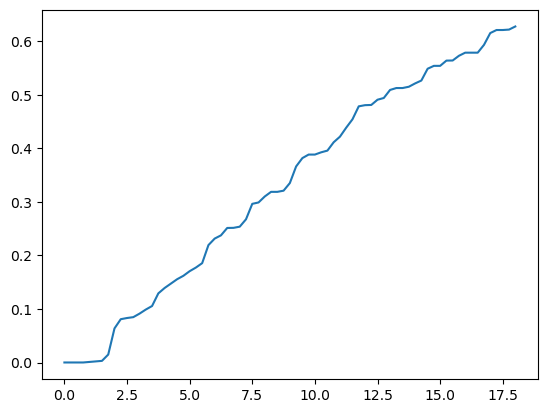

In [202]:
plt.plot(x, spl(x))

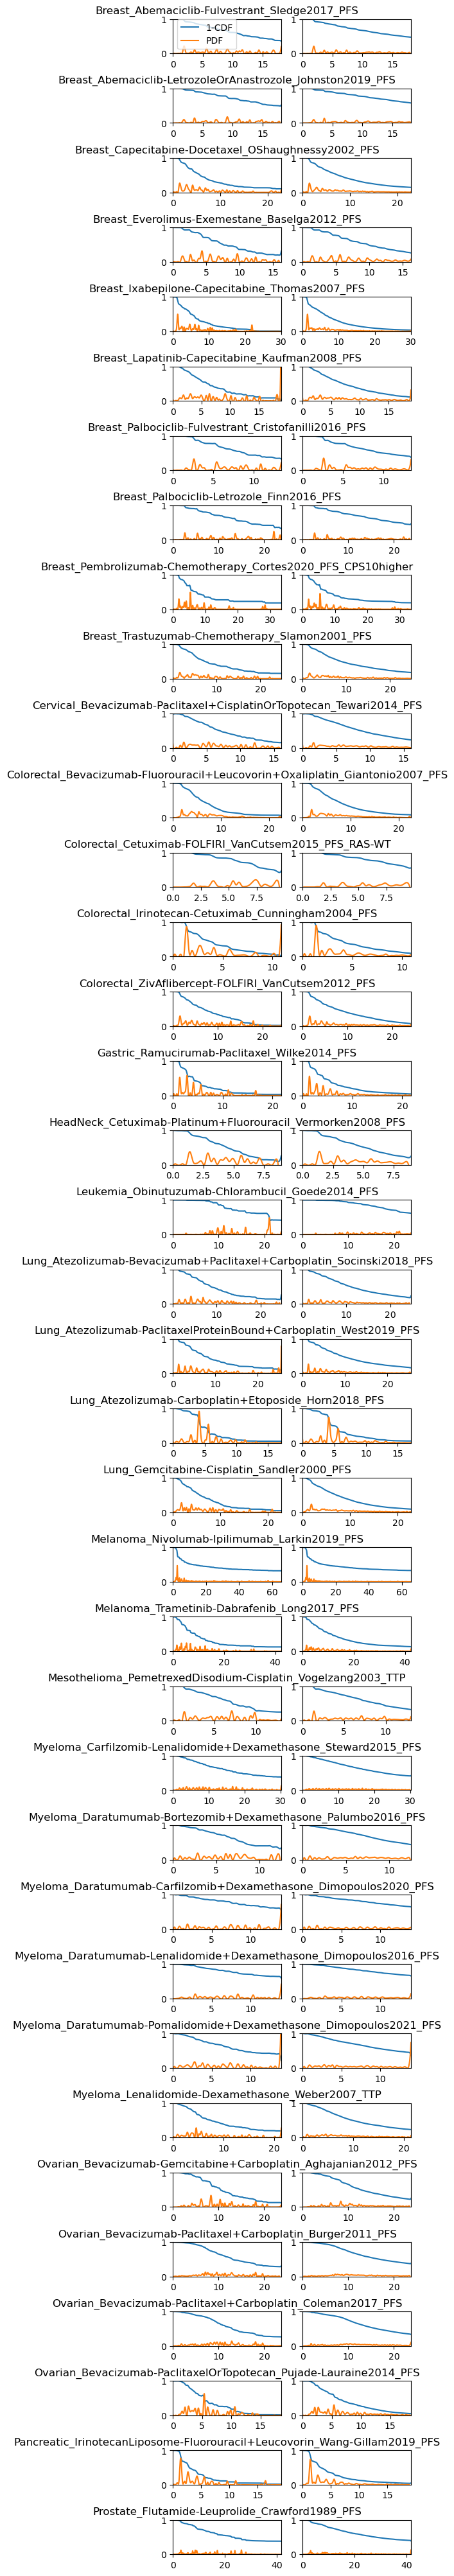

In [182]:
# Check if smoothing works
tstep = 0.25
babystep = 0.01
tmp = df
fig, axes = plt.subplots(tmp.shape[0], 2, figsize=(4, 40), constrained_layout=True)
for i in range(tmp.shape[0]):
    name_a = tmp.at[i, 'Experimental']
    name_b = tmp.at[i, 'Control']
    name_ab = tmp.at[i, 'Combination']
    n_combo = tmp.at[i, 'N_combination']
    # import prediction
    independent = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_ind.csv').dropna()
    additive = pd.read_csv(f'{PFS_PRED_DIR}/{name_a}-{name_b}_combination_predicted_add.csv').dropna()
    models = [independent, additive]
    axes[i, 0].set_title(name_ab)
    for k in range(len(models)):
        model = models[k]
        tmax = model['Time'].max() - tstep
        f = interp1d(model['Time'], (100 - model['Survival'])/100, kind='zero', fill_value='extrapolate')
        x = np.arange(0, tmax, tstep)
        y = f(x)

        spl = make_interp_spline(x, y, k=5)
        more_x = np.arange(0, tmax, babystep)
        dydx = spl.derivative()
        axes[i, k].plot(more_x, 1 - spl(more_x), label='1-CDF')
        axes[i, k].plot(more_x, dydx(more_x), label='PDF')
        axes[i, k].set_xlim(0, tmax)
        axes[i, k].set_ylim(0, 1)

axes[0, 0].legend()
fig.savefig(f'{OUTDIR}/spline_sanity_check.pdf')


In [106]:
f_ind = interp1d(independent['Time'], (100 - independent['Survival'])/100, kind='zero', fill_value='extrapolate')
tstep = 0.25
x = np.arange(0, independent['Time'].max() - tstep, tstep)
y = f_ind(x)

In [142]:
spl = splrep(x, y, k=5, s=0.0004)
more_x = np.arange(0, independent['Time'].max() - 0.01, 0.01)
more_y = splev(more_x, spl)
dydx = splev(more_x, spl, der=1)


In [173]:
spl = make_interp_spline(x, y, k=5)
more_x = np.arange(0, independent['Time'].max() - 0.01, 0.01)
dydx = spl.derivative()


In [174]:
dydx.integrate(10, 15)

array(0.166)

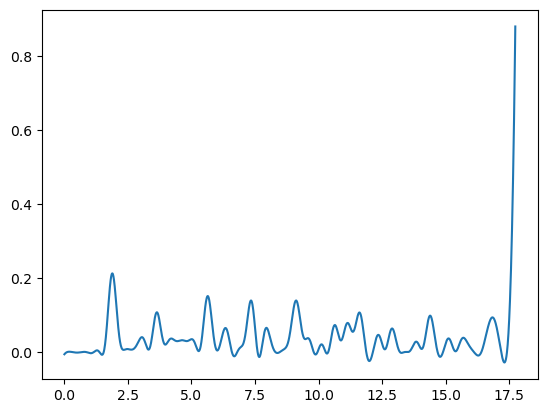

In [170]:
plt.plot(more_x, more_y(more_x))
#plt.ylim(0, 1)

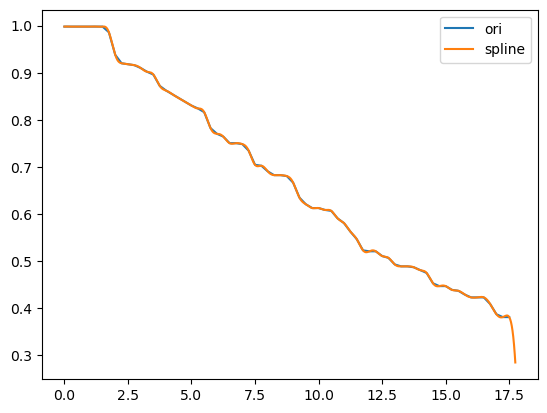

In [171]:
plt.plot(x, 1 - y, label='ori')
#plt.plot(more_x, 1 - more_y, label='spline')
plt.plot(more_x, 1 - spl(more_x), label='spline')

plt.legend()

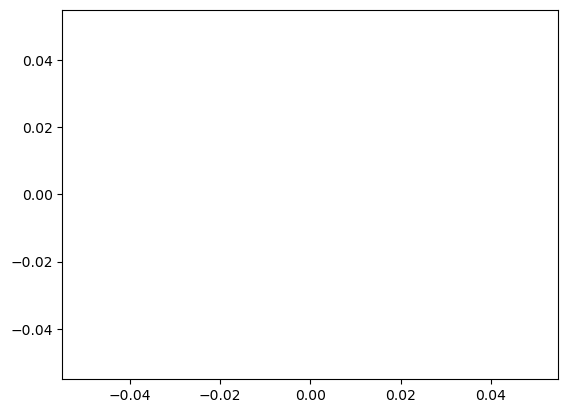

In [80]:
fig, ax = plt.subplots()
ax.plot(independent['Time'][::-1], y)
#ax.plot(independent['Time'][::-1], independent['Survival'][::-1])


In [66]:
def d_fun(fun, x):
    h = 1e-5
    return (fun(x+h)-fun(x-h))/(2*h)


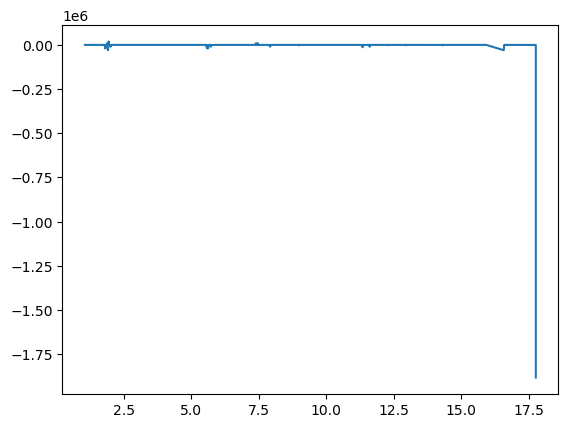

In [67]:
fig, ax = plt.subplots()
ax.plot(independent['Time'][::-1], d_fun(f, independent['Time'][::-1]))
